Collect stock and option data, price with BSM, compare accuracy

In [21]:
import os
import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

from datetime import datetime, timezone, timedelta


In [22]:
# !pip install lxml
# import lxml


In [23]:
# initial parameters

ticker = 'GOOG'
rfr = []
# risk_free_rate = 0.08
#option_type = 'put'

# 2 weeks, 1m, 3m, 6m, 1yr
expiration_datetime = []
expiration_datetime.append(datetime(2020, 12, 18, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 1, 8, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 3, 19, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 6, 18, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 10, 15, 0, 0, tzinfo=timezone.utc))

# expiration_datetime = datetime(2020, 12, 11, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2020, 12, 24, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2021, 2, 19, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2021, 6, 18, 0, 0, tzinfo=timezone.utc)


In [24]:
# get a UTC timestamp from a date. This is used to scrape data from Yahoo Finance.

expiration_timestamp = []
for x in expiration_datetime:
    expiration_timestamp.append(int(x.timestamp()))

print(expiration_timestamp)
for x in expiration_timestamp:
    print(datetime.fromtimestamp(x)) # this is in UTC, add 5 hours to this to get EST

[1608249600, 1610064000, 1616112000, 1623974400, 1634256000]
2020-12-18 00:00:00
2021-01-08 00:00:00
2021-03-19 00:00:00
2021-06-18 00:00:00
2021-10-15 00:00:00


## Below we create the data fram from the yahoo historical data.

Download historical stock price data for Google (GOOG). I get a past year's worth from (https://finance.yahoo.com/quote/GOOG/history?p=GOOG)

In [25]:
import time
# 1

# download annual historical data for the stock

# stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
stock_price_path = "price_data/{}.csv".format(ticker)
options_data_path = []
for x in expiration_timestamp:
    options_data_path.append('https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, x, ticker))

df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))

# percent change in price from day before
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)
#get rid of first day in data, since we can't find price from day before
df = df.dropna()
df = df.drop(['Open','High','Low','Close'],axis=1)

# get options data, save
print(options_data_path)
options_data = []
for i,x in enumerate(options_data_path):
    options_df_list = pd.read_html(x)
    options_data.append(options_df_list) # returns two dataframes, for calls and puts
    collection_date = str(datetime.now().date())
    save_path = "price_data/{}".format(collection_date)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    options_df_list[0].to_csv("price_data/{}/{}_{}_calls.csv".format(collection_date, ticker, expiration_timestamp[i]))
    options_df_list[1].to_csv("price_data/{}/{}_{}_puts.csv".format(collection_date, ticker, expiration_timestamp[i]))
    
    time.sleep(1)

calls_df = []
puts_df = []
for x in options_data:

    x[0]['Volume'] = x[0]['Volume'].replace('-','0')
    x[0] = x[0].replace('-',np.NaN)
    x[1]['Volume'] = x[1]['Volume'].replace('-','0')
    x[1] = x[1].replace('-',np.NaN)
    x[1]['Implied Volatility'] = x[1]['Implied Volatility'].str.slice(stop=-1)
    x[0]['Implied Volatility'] = x[0]['Implied Volatility'].str.slice(stop=-1)
    x[1]['Implied Volatility'] = x[1]['Implied Volatility'].astype(float)/100
    x[0]['Implied Volatility'] = x[0]['Implied Volatility'].astype(float)/100
    x[1] = x[1][x[1]['Implied Volatility'] != 0].reset_index()
    x[0] = x[0][x[0]['Implied Volatility'] != 0].reset_index()

 
    # code for filtering the options data to be only actively traded options

#    x[0] = x[0][(x[0]['Open Interest'].astype('int') > 15)].reset_index()
#    x[0] = x[0][(x[0]['Volume'].astype('int') > 1)].reset_index()
#    x[1] = x[1][(x[1]['Open Interest'].astype('int') > 15)].reset_index()
#    x[1] = x[1][(x[1]['Volume'].astype('int') > 1)].reset_index()
    
    calls_df.append(x[0])
    puts_df.append(x[1])

#print(df)
#print(calls_df)
#print(puts_df)

['https://finance.yahoo.com/quote/GOOG/options?date=1608249600&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1610064000&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1616112000&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1623974400&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1634256000&p=GOOG']


       Date  1 mo  2 mo  3 mo  6 mo  1 yr  2 yr  3 yr  5 yr  7 yr  10 yr  \
0  12/01/20  0.07  0.07  0.09  0.10  0.12  0.17  0.22  0.42  0.68   0.92   
1  12/02/20  0.07  0.08  0.09  0.10  0.11  0.16  0.22  0.42  0.69   0.95   
2  12/03/20  0.08  0.08  0.08  0.09  0.10  0.16  0.21  0.40  0.67   0.92   
3  12/04/20  0.07  0.07  0.09  0.10  0.11  0.16  0.21  0.42  0.70   0.97   

   20 yr  30 yr  
0   1.46   1.66  
1   1.50   1.70  
2   1.46   1.67  
3   1.53   1.73  


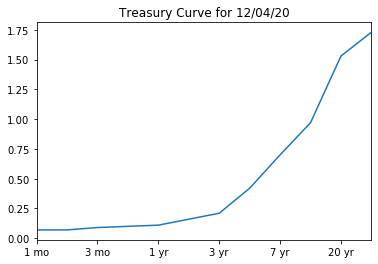

In [26]:
# 2
# get risk free rate data

rfr_data_path = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
rfr_df = pd.read_html(rfr_data_path)[1] # returns two dataframes, for calls and puts
print(rfr_df)

# next we plot the rfr

# find the date from this data
rfr_date = rfr_df.iloc[-1][0]

cur_rfr = rfr_df.iloc[-1][1:].astype(float)
cur_rfr.plot(title="Treasury Curve for {}".format(rfr_date))

In [27]:
# 3
# BSM model algorithm using SciPy for the normal distribution
# Explicit formula for solving European Option Prices

# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma, option_type):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type=='call':
        return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    elif option_type=='put':
        return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
        
# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [28]:
# Testing the model

value_s = black_scholes(S = 69, 
                        K = 70, 
                        T = 6/12, 
                        r = .05, 
                        sigma = .35,
                        option_type='put')
print(value_s)

6.401407649076464


In [29]:
# 4

# the rfr should vary with time, not be constant.
rfr = []
for x in [1,1,3,4,5]:
    rfr.append(rfr_df.iloc[-1][x].astype(float))

cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = []
for x in expiration_datetime:
    time_to_expiration.append(get_time_to_expiration(x))



# Calculate the volatility as the annualized standard deviation of the stock returns
## The stock market has had a crazy year, perhaps we want the volatility to be measured only in the last 6 months. 
sigma = np.sqrt(252) * df['returns'].std()

## Do interest rates need to be adjusted with day counts? need to look into this

rfr_time = tuple(zip(time_to_expiration, rfr))
print(rfr_time)

for x in rfr_time:
    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, sigma: {}'.format(cur_stock_price, x[0], x[1], sigma))

calls_index = []
puts_index = []
for x in calls_df:
    strike_start_idx, strike_end_idx = 0, x.shape[0]
    calls_index.append((strike_start_idx,strike_end_idx))

#print(puts_df[0].shape[0])
    
for x in puts_df:
    strike_start_idx, strike_end_idx = 0, x.shape[0]
    puts_index.append((strike_start_idx,strike_end_idx))

    
calls_estimate = dict()
puts_estimate = dict()
for x in range(0,5):
    calls_estimate.update({x: []})
    puts_estimate.update({x: []})

#for x in rfr_time:
#    print(calls_estimate[x])
#    calls_estimate[x].append(1)
#    print(calls_estimate[x])

calls_estimate_df = []

#for each strike date, run BSM for different strikes on calls
for i in range(0,5):
    for x in range(calls_index[i][0],calls_index[i][1]):
        value_s = black_scholes(S = cur_stock_price, 
                                K = calls_df[i]['Strike'][x], 
                                T = time_to_expiration[i], 
                                r = rfr[i], 
                                sigma = sigma,
                                option_type = 'call')
        calls_estimate[i].append(value_s)
    
# merge the real and computed dataframes to compare results
    #print(calls_estimate[i])
    df_list = pd.DataFrame(data=calls_estimate[i], index=calls_df[i].index[calls_index[i][0]:calls_index[i][1]])
    #print(df_list)
    df_list['estimate'] = df_list[0]
    del df_list[0]
    calls_estimate_df.append(calls_df[i].merge(df_list, right_index = True, left_index = True))
    
puts_estimate_df = []

#for each strike date, run BSM for different strikes on calls
for i in range(0,5):
    for x in range(puts_index[i][0],puts_index[i][1]):
        value_s = black_scholes(S = cur_stock_price, 
                                K = puts_df[i]['Strike'][x], 
                                T = time_to_expiration[i], 
                                r = rfr[i], 
                                sigma = sigma,
                                option_type = 'put')
        puts_estimate[i].append(value_s)
    
# merge the real and computed dataframes to compare results
    #print(calls_estimate[i])
    df_list = pd.DataFrame(data=puts_estimate[i], index=puts_df[i].index[puts_index[i][0]:puts_index[i][1]])
    #print(df_list)
    df_list['estimate'] = df_list[0]
    del df_list[0]
    puts_estimate_df.append(puts_df[i].merge(df_list, right_index = True, left_index = True))
    

((0.04365079365079365, 0.07), (0.12698412698412698, 0.07), (0.40476190476190477, 0.09), (0.7658730158730159, 0.1), (1.2380952380952381, 0.11))
cur_stock_price: 1827.9899899999998, time to expiration: 0.04365079365079365, rfr: 0.07, sigma: 0.38312833939478125
cur_stock_price: 1827.9899899999998, time to expiration: 0.12698412698412698, rfr: 0.07, sigma: 0.38312833939478125
cur_stock_price: 1827.9899899999998, time to expiration: 0.40476190476190477, rfr: 0.09, sigma: 0.38312833939478125
cur_stock_price: 1827.9899899999998, time to expiration: 0.7658730158730159, rfr: 0.1, sigma: 0.38312833939478125
cur_stock_price: 1827.9899899999998, time to expiration: 1.2380952380952381, rfr: 0.11, sigma: 0.38312833939478125


In [46]:
for df_list in [calls_estimate_df, puts_estimate_df]:
    for df in df_list:
        df['Mid Price'] = (df['Ask'] + df['Bid'])/2


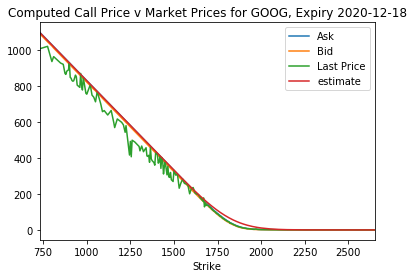

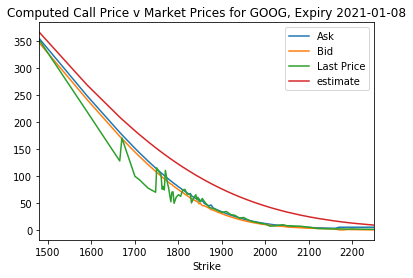

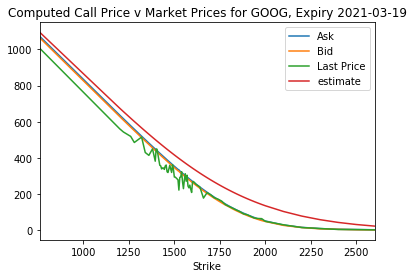

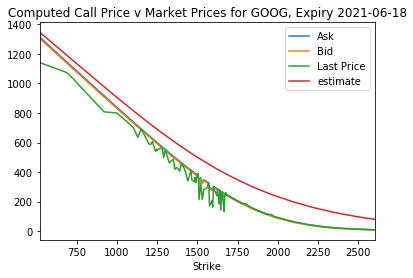

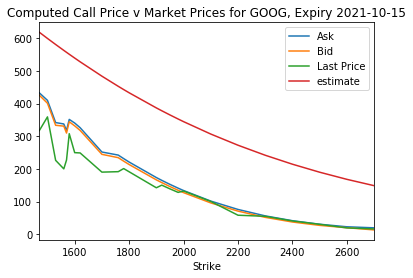

In [30]:
# plot call prices across strikes

for i in range(0,5):
    calls_estimate_df[i].plot(x='Strike',y=['Ask','Bid','Last Price','estimate'], title='Computed Call Price v Market Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))

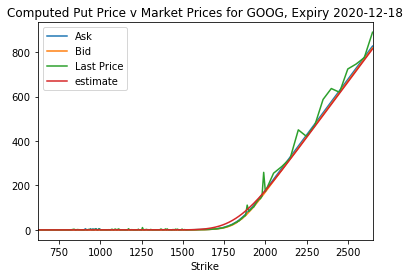

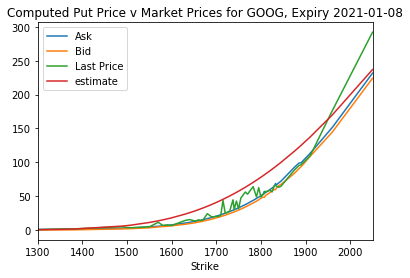

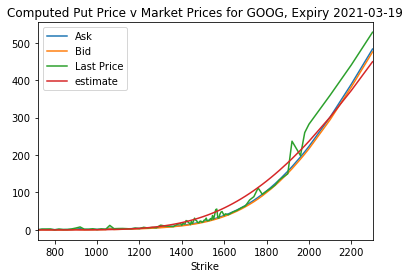

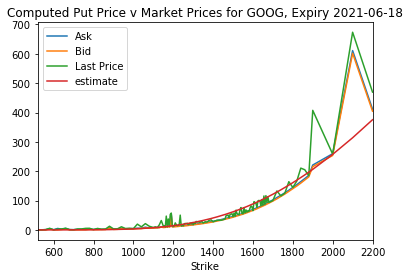

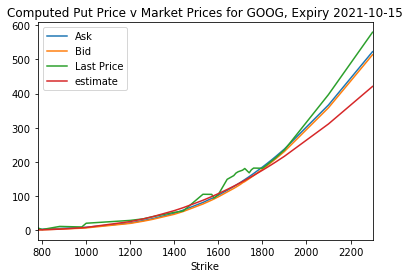

In [31]:
# plot put prices across strikes

for i in range(0,5):
    puts_estimate_df[i].plot(x='Strike',y=['Ask','Bid','Last Price','estimate'], title='Computed Put Price v Market Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))

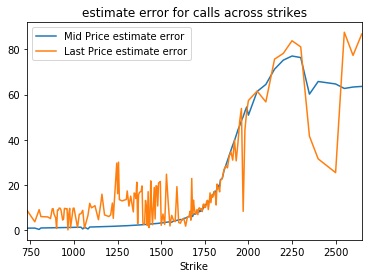

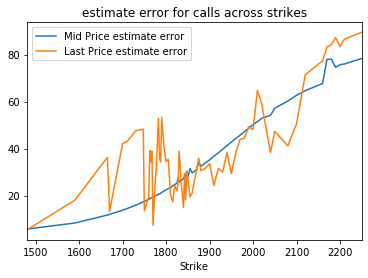

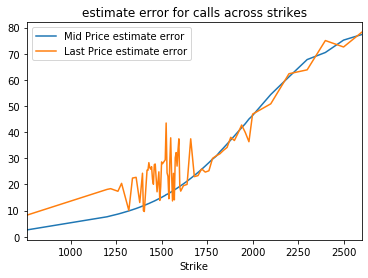

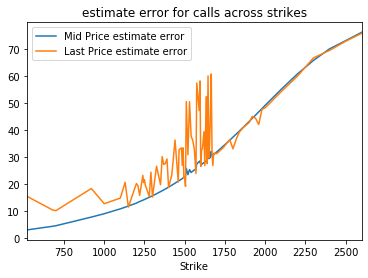

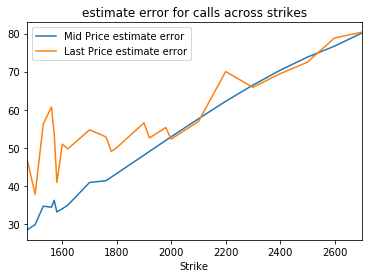

In [50]:
## calls error

# error_types = ['Ask_estimate_error','Bid_estimate_error','Last Price_estimate_error','mid_price_estimate_error']
features = ['Last Price','Mid Price']

for feature in features:
    for df_list in [calls_estimate_df, puts_estimate_df]:
        for df in df_list:
            feature_error_name = feature + " estimate error"
            df[feature_error_name] = ((abs(df[feature] - df['estimate'])/df['estimate']))*100
            

# across strikes, the median error is 34%, but there is a huge spread and outliers, 
# which mainly seem to be due to the higher strikes being very close to 0.

# plot the error across strikes
for i in range(0,5):
#     for j in range (0,3):
#         calls_estimate_df[i][error_types[j]] = ((abs(calls_estimate_df[i]['Last Price'] - calls_estimate_df[i]['estimate'])/calls_estimate_df[i]['estimate']))*100
        #ax = sns.distplot(calls_estimate_df[i]['last_estimate_error'])
        #print(calls_estimate_df[i]['last_estimate_error'].describe())

    calls_estimate_df[i].plot(x='Strike',y=['Mid Price estimate error','Last Price estimate error'],title='estimate error for calls across strikes')

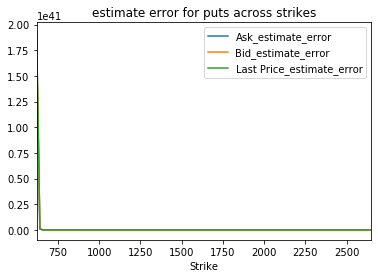

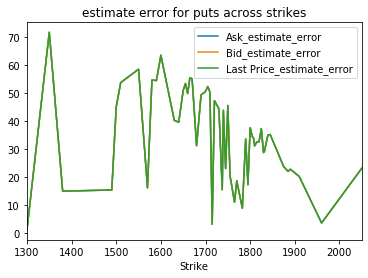

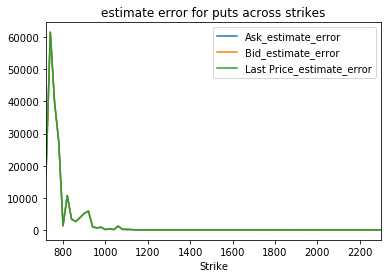

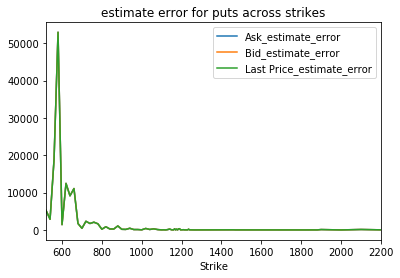

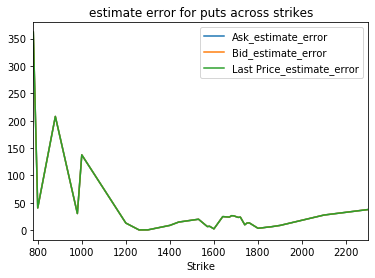

In [33]:
## puts error

# error_types = ['Ask_estimate_error','Bid_estimate_error','Last Price_estimate_error']

for i in range(0,5):
#     for j in range (0,3):
#         puts_estimate_df[i][error_types[j]] = ((abs(puts_estimate_df[i]['Last Price'] - puts_estimate_df[i]['estimate'])/puts_estimate_df[i]['estimate']))*100
        #ax = sns.distplot(calls_estimate_df[i]['last_estimate_error'])
        #print(calls_estimate_df[i]['last_estimate_error'].describe())

# across strikes, the median error is 34%, but there is a huge spread and outliers, 
# which mainly seem to be due to the higher strikes being very close to 0.

# plot the error across strikes

    puts_estimate_df[i].plot(x='Strike',y=['Ask_estimate_error','Bid_estimate_error','Last Price_estimate_error'],title='estimate error for puts across strikes')

In [34]:
# calls_estimate = dict()
# puts_estimate = dict()
# for x in range(0,5):
#     calls_estimate.update({x: []})
#     puts_estimate.update({x: []})


# calls_estimate_df = []

# #for each strike date, run BSM for different strikes on calls
# for i in range(0,5):
#     for x in range(calls_index[i][0],calls_index[i][1]):
#         value_s = black_scholes(S = cur_stock_price, 
#                                 K = calls_df[i]['Strike'][x], 
#                                 T = time_to_expiration[i], 
#                                 r = rfr[i], 
#                                 sigma = calls_df[i]['Implied Volatility'][x],
#                                 option_type = 'call')
#         calls_estimate[i].append(value_s)
    
# # merge the real and computed dataframes to compare results
#     #print(calls_estimate[i])
#     df_list = pd.DataFrame(data=calls_estimate[i], index=calls_df[i].index[calls_index[i][0]:calls_index[i][1]])
#     #print(df_list)
#     df_list['estimate'] = df_list[0]
#     del df_list[0]
#     calls_estimate_df.append(calls_df[i].merge(df_list, right_index = True, left_index = True))

    
# puts_estimate_df = []

# #for each strike date, run BSM for different strikes on calls
# for i in range(0,5):
#     for x in range(puts_index[i][0],puts_index[i][1]):
#         value_s = black_scholes(S = cur_stock_price, 
#                                 K = puts_df[i]['Strike'][x], 
#                                 T = time_to_expiration[i], 
#                                 r = rfr[i], 
#                                 sigma =  puts_df[i]['Implied Volatility'][x],
#                                 option_type = 'put')
#         puts_estimate[i].append(value_s)
    
# # merge the real and computed dataframes to compare results
#     #print(calls_estimate[i])
#     df_list = pd.DataFrame(data=puts_estimate[i], index=puts_df[i].index[puts_index[i][0]:puts_index[i][1]])
#     #print(df_list)
#     df_list['estimate'] = df_list[0]
#     del df_list[0]
#     puts_estimate_df.append(puts_df[i].merge(df_list, right_index = True, left_index = True))
    

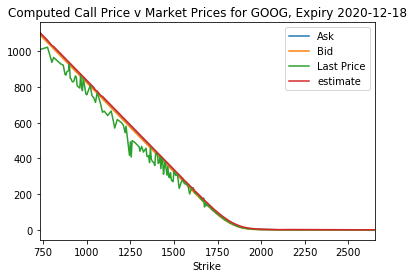

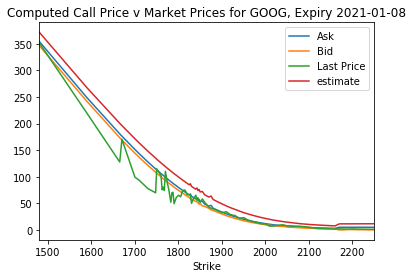

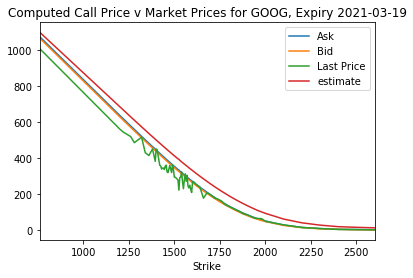

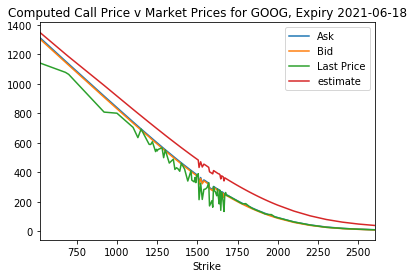

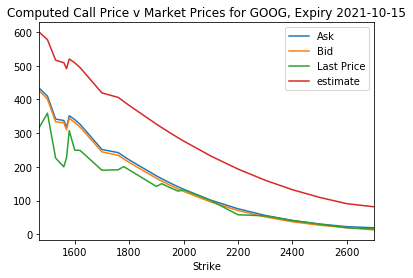

In [35]:
# # plot call prices across strikes

# for i in range(0,5):
#     calls_estimate_df[i].plot(x='Strike',y=['Ask','Bid','Last Price','estimate'], title='Computed Call Price v Market Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))

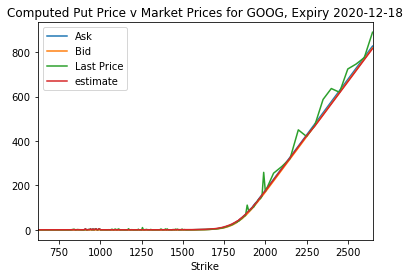

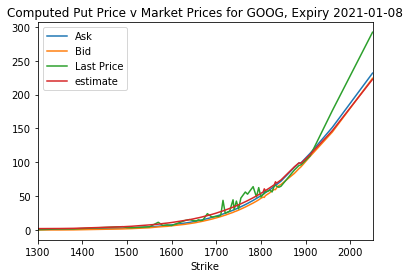

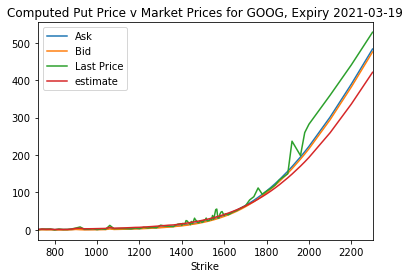

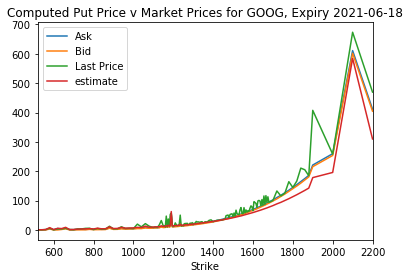

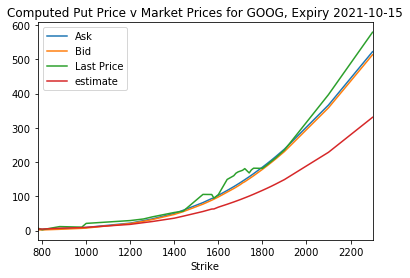

In [36]:
# # plot put prices across strikes

# for i in range(0,5):
#     puts_estimate_df[i].plot(x='Strike',y=['Ask','Bid','Last Price','estimate'], title='Computed Put Price v Market Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))

In [51]:
# ## calls error

# error_types = ['Ask_estimate_error','Bid_estimate_error','Last Price_estimate_error']

# for i in range(0,5):
#     for j in range (0,3):
#         calls_estimate_df[i][error_types[j]] = ((abs(calls_estimate_df[i]['Last Price'] - calls_estimate_df[i]['estimate'])/calls_estimate_df[i]['estimate']))*100
#         #ax = sns.distplot(calls_estimate_df[i]['last_estimate_error'])
#         #print(calls_estimate_df[i]['last_estimate_error'].describe())

# # across strikes, the median error is 34%, but there is a huge spread and outliers, 
# # which mainly seem to be due to the higher strikes being very close to 0.

# # plot the error across strikes

#     calls_estimate_df[i].plot(x='Strike',y=['Ask_estimate_error','Bid_estimate_error','Last Price_estimate_error'],title='estimate error for calls across strikes')

In [52]:
# ## puts error

# error_types = ['Ask_estimate_error','Bid_estimate_error','Last Price_estimate_error']

# for i in range(0,5):
#     for j in range (0,3):
#         puts_estimate_df[i][error_types[j]] = ((abs(puts_estimate_df[i]['Last Price'] - puts_estimate_df[i]['estimate'])/puts_estimate_df[i]['estimate']))*100
#         #ax = sns.distplot(calls_estimate_df[i]['last_estimate_error'])
#         #print(calls_estimate_df[i]['last_estimate_error'].describe())

# # across strikes, the median error is 34%, but there is a huge spread and outliers, 
# # which mainly seem to be due to the higher strikes being very close to 0.

# # plot the error across strikes

#     puts_estimate_df[i].plot(x='Strike',y=['Ask_estimate_error','Bid_estimate_error','Last Price_estimate_error'],title='estimate error for puts across strikes')

In [44]:


# what is a measure of error?
# MSE: average of the sum of squared errors

mse = np.sum((df_estimate['Mid Price'] - df_estimate['estimate'])**2) / df_estimate.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)
# could also try MAD

186.3189464727641 13.64986983354655


In [53]:
# examine outliers

# df_estimate[df_estimate['estimate_error'].abs() > 1]

# the model tends to undervalue puts especially at high strikes (deep out of the money).

In [ ]:
# # how accurate are our vol estimates?

# df_estimate['Implied Volatility'] = df_estimate['Implied Volatility'].str.replace(',','').str.slice(stop=-1).astype('float') / 100

# df_estimate['Historical Vol'] = sigma
# ax = df_estimate.plot(x='Strike',y=['Implied Volatility','Historical Vol'],title='volatility across strikes')

In [ ]:
# df_estimate['Volume'] = df_estimate['Volume'].replace(to_replace='-',value=0)
# df_estimate['Volume'] = df_estimate['Volume'].astype('int')

# df_estimate['Open Interest'] = df_estimate['Open Interest'].replace(to_replace='-',value=0)
# df_estimate['Open Interest'] = df_estimate['Open Interest'].astype('int')

# df_estimate.plot(x='Strike',y=['Volume','Open Interest'],title='volume and open interest')

In [ ]:
# sns.distplot(df_estimate['Open Interest'])
# print(df_estimate['Open Interest'].describe())

In [ ]:
# # filter out low volume options


# price_estimate_filtered = df_estimate[(df_estimate['Open Interest'] > 15)].reset_index()
# ax = sns.distplot(price_estimate_filtered['estimate_error'])
# print(price_estimate_filtered['estimate_error'].describe())

# price_estimate_filtered.plot(x='Strike',y=['Last Price','estimate'], title='Option prices for {}, Expiry {} (Filtered Strikes)'.format(ticker, expiration_datetime.date()))


In [ ]:

# df_estimate_european['estimate_with_implied_error'] = ((df_estimate_european['Last Price'] - df_estimate_european['estimate_with_implied'])/df_estimate_european['estimate_with_implied'])*100
# ax = sns.distplot(df_estimate_european['estimate_with_implied_error'])
# print(df_estimate_european['estimate_with_implied_error'].describe())
# df_estimate_european.plot(x='Strike',y='estimate_with_implied_error',title='Estimate Percent Error Across Strikes (Filtered Strikes)')

# mse = np.sum((df_estimate_european['Last Price'] - df_estimate_european['estimate_with_implied'])**2) / df_estimate_european.shape[0]
# rmse = np.sqrt(mse)

# print(mse, rmse)

In [40]:
# Numerical methods for American options

from functions.BS_pricer import BS_pricer
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process
from functions.cython.cython_functions import PSOR

import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))
    

In [130]:
# PDE method

def price_american_PDE(S0, K, T, r, sigma, payoff='call', N_space = 8000, N_time = 5000):
    
    # Creates the object with the parameters of the option
    opt_param = Option_param(S0=S0, K=K, T=T, exercise="American", payoff=payoff )
    # Creates the object with the parameters of the process
    diff_param = Diffusion_process(r=r, sig=sigma)
    # Creates the pricer object
    BS = BS_pricer(opt_param, diff_param)
    
#     return BS.LSM(N=1000, paths=1000, order=2)  # Longstaff Schwartz Method, has problems with polynomial fitting
#     N_space = 8000
#     N_time = 5000
    return BS.PDE_price((N_space,N_time))


In [123]:
# price_american(S0=100, K=100, T=1, r=0.1, sigma=0.2, payoff="put" )
# 1827.949951 1110.0 0.7817460317460317 0.08 0.38212781123440914 put
price_american(S0=1827.949951, K=1110.0, T=0.7817460317460317, r=0.08, sigma=0.38212781123440914, payoff="put" )

In [110]:
# analyze convergence of PDE method, grid search over space and time

import time

space_vals = [10,100,1000,8000]
time_vals = [10,100,1000,5000]

data = []
for N_space in space_vals:
    row = []
    for N_time in time_vals:
        start = time.clock()
        price = price_american(S0=1827.949951, 
                               K=1110.0, 
                               T=0.7817460317460317, 
                               r=0.08, 
                               sigma=0.38212781123440914, 
                               payoff="put",
                               N_space=N_space,
                               N_time=N_time)
        runtime = time.clock() - start
        print("price: {}, runtime: {}, space: {}, time: {}".format(price, runtime, N_space, N_time))
        
        row.append((price, runtime))
    data.append(row)
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


price: 18.955538877198485, runtime: 0.004606999999964501, space: 10, time: 10
price: 19.095356353831328, runtime: 0.0036020000000007713, space: 10, time: 100
price: 19.1074943142453, runtime: 0.009657999999944877, space: 10, time: 1000
price: 19.108558678992942, runtime: 0.039116999999919244, space: 10, time: 5000
price: 9.884361568586858, runtime: 0.002032999999983076, space: 100, time: 10
price: 9.649536973279437, runtime: 0.0026420000000371147, space: 100, time: 100
price: 9.635631066675161, runtime: 0.013101000000006024, space: 100, time: 1000
price: 9.634776511753065, runtime: 0.0579529999999977, space: 100, time: 5000
price: 9.804857774674838, runtime: 0.0027279999999336724, space: 1000, time: 10
price: 9.57052931665908, runtime: 0.00550399999997353, space: 1000, time: 100
price: 9.559967111771446, runtime: 0.0472740000000158, space: 1000, time: 1000
price: 9.559916883977557, runtime: 0.24222499999996217, space: 1000, time: 5000
price: 9.80398556690522, runtime: 0.007758999999964

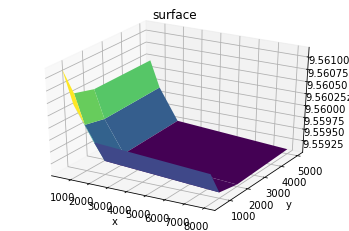

In [108]:
from mpl_toolkits import mplot3d

def get_price(x, y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))
    return price_american(S0=1827.949951, 
                               K=1110.0, 
                               T=0.7817460317460317, 
                               r=0.08, 
                               sigma=0.38212781123440914, 
                               payoff="put",
                               N_space=x,
                               N_time=y)

f = np.vectorize(get_price)

space_vals = np.array([500,1000,2000,8000])
time_vals = np.array([500,1000,2000,5000])

X, Y = np.meshgrid(space_vals, time_vals)
Z = f(X, Y)
fig = plt.figure()

ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [133]:
# binomial trees

def price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = 8000):
    
    dT = float(T) / N                             # Delta t
    u = np.exp(sig * np.sqrt(dT))                 # up factor
    d = 1.0 / u                                   # down factor 

    V = np.zeros(N+1)                             # initialize the price vector
    S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

    a = np.exp(r * dT)    # risk free compound return
    p = (a - d)/ (u - d)  # risk neutral up probability
    q = 1.0 - p           # risk neutral down probability   

    if payoff =="call":
        V[:] = np.maximum(S_T-K, 0.0)
    elif payoff =="put":
        V[:] = np.maximum(K-S_T, 0.0)

    for i in range(N-1, -1, -1):
        V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
        S_T = S_T * u                    # it is a tricky way to obtain the price at the previous time step
        if payoff=="call":
            V = np.maximum( V, S_T-K )
        elif payoff=="put":
            V = np.maximum( V, K-S_T )

#     print("American BS Tree Price: ", V[0])
    
    return V[0]

In [113]:
S0=100.0    # spot stock price
K=100.0     # strike
T=1.0       # maturity 
r=0.1       # risk free rate 
sig=0.2     # diffusion coefficient or volatility

N = 25000              # number of periods or number of time steps  
payoff = "put"        # payoff 

price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = 8000)

American BS Tree Price:  13.269415562733911


In [120]:
# plot as we vary N

iterations = [500,1000, 2000, 4000, 8000, 16000, 25000]
prices = []
runtimes = []

for N in iterations:
    start = time.clock()
    price = price_american_binomial_tree(S0, K, T, r, sig, payoff='put', N = N)
    runtimes.append(time.clock() - start)
    prices.append(price)

df_btree = pd.DataFrame({'N':iterations, 'price':prices, 'runtime':runtimes})
df_btree.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


American BS Tree Price:  4.8147014897529194
American BS Tree Price:  4.815465694807252
American BS Tree Price:  4.815879015728361
American BS Tree Price:  4.816081529233179
American BS Tree Price:  4.81618177994254
American BS Tree Price:  4.816230884548013
American BS Tree Price:  4.81624866310944


,N,price,runtime
0,500,4.814701,0.009852
1,1000,4.815466,0.015759
2,2000,4.815879,0.044134
3,4000,4.816082,0.097925
4,8000,4.816182,0.305659


Text(0, 0.5, 'runtime (s)')

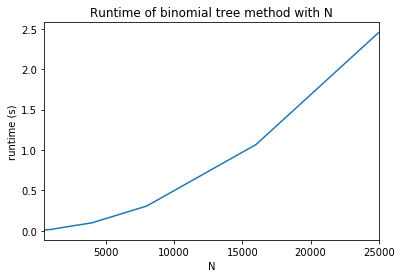

In [143]:
# ax1 = df_btree.plot(x='N',y=['price'])

# df_btree = df_btree.set_index('N')
# df_btree['price'].plot()
# df_btree['runtime'].plot(secondary_y=True)

# ax1 = df_btree.plot(x='N',y=['price'])
# df_btree.plot(x='N',y='runtime',secondary_y=True)
# ax1.set_title("Estimate of binomial tree method with N")
# ax1.set_ylabel("price")

ax2 = df_btree['runtime'].plot() 
# ax2 = df_btree.plot(x='N',y='runtime')
ax2.set_title("Runtime of binomial tree method with N")
ax2.set_ylabel("runtime (s)")



In [131]:
# PDE method

def price_american(S0, K, T, r, sigma, payoff, model='binomial_tree'):
    
    if model == 'binomial_tree':
        return price_american_binomial_tree(S0, K, T, r, sigma, payoff=payoff, N=4000)
    elif model == 'PDE':
        return price_american_PDE(S0, K, T, r, sigma, payoff=payoff, N_space = 4000, N_time = 2000)


In [151]:
%%time

# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes_american(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type, model):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    index = []
    list_estimates = []
#     estimates_with_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]
    step = 5

    # run BSM for different strikes
    for x in range(strike_start_idx,strike_end_idx, step):
        index.append(x)
#         print('strike', options_df['Strike'][x])
        value_s = price_american(S0 = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                payoff = option_type,
                                model = model)
        list_estimates.append(value_s)
        
        # same calcs but with implied vol
#         print(cur_stock_price, options_df['Strike'][x], time_to_expiration, risk_free_rate, options_df['Implied Volatility'][x], option_type)
#         value_s = price_american(S0 = cur_stock_price, 
#                                 K = options_df['Strike'][x], 
#                                 T = time_to_expiration, 
#                                 r = risk_free_rate, 
#                                 sigma = options_df['Implied Volatility'][x],
#                                 payoff = option_type)
#         estimates_with_implied.append(value_s)

    # merge the real and computed dataframes to compare results
    price_estimates = pd.Series(data=list_estimates, index=index)
#     print('price estimates: ', price_estimates)
#     df_estimate['estimate_with_implied'] = estimates_with_implied
    df_estimate = options_df[['Strike','Mid Price']]
    df_estimate['estimate'] = price_estimates

    return df_estimate

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [146]:
# error analysis of PDE method



1827.9899899999998 [0.04365079365079365, 0.12698412698412698, 0.40476190476190477, 0.7658730158730159, 1.2380952380952381] 0.08 0.38312833939478125 put
cur_stock_price: 1827.9899899999998, time to expiration: 0.04365079365079365, rfr: 0.08, vol: 0.38312833939478125


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


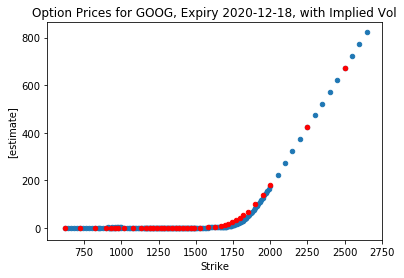

cur_stock_price: 1827.9899899999998, time to expiration: 0.12698412698412698, rfr: 0.08, vol: 0.38312833939478125


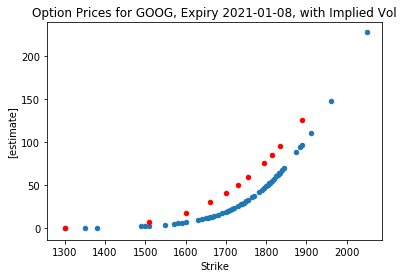

cur_stock_price: 1827.9899899999998, time to expiration: 0.40476190476190477, rfr: 0.08, vol: 0.38312833939478125


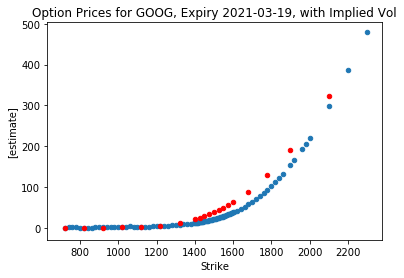

cur_stock_price: 1827.9899899999998, time to expiration: 0.7658730158730159, rfr: 0.08, vol: 0.38312833939478125


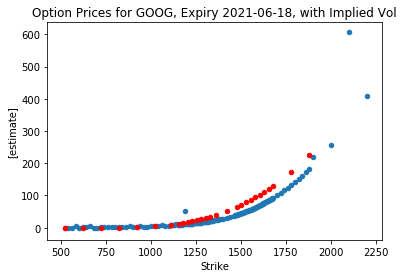

cur_stock_price: 1827.9899899999998, time to expiration: 1.2380952380952381, rfr: 0.08, vol: 0.38312833939478125


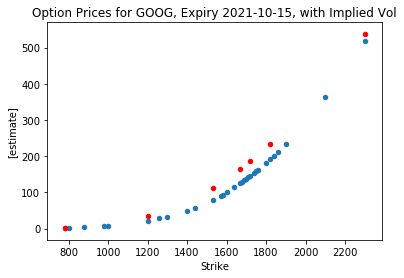

CPU times: user 11.4 s, sys: 843 ms, total: 12.3 s
Wall time: 11.2 s


In [152]:
%%time

import matplotlib.pyplot as plt
# df_estimate_american = calculate_prices_across_strikes_american(price_estimate_filtered, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type)

# ax1 = df_estimate_american.plot(kind='scatter', x='Strike',y=['Last Price'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))
# df_estimate_american.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r')


# price_estimate_filtered = puts_estimate_df[0]
print(cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type)

for i,df in enumerate(puts_estimate_df):
    option_type = 'put'
    df_estimate_american = calculate_prices_across_strikes_american(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')

    ax1 = df_estimate_american.plot(kind='scatter', x='Strike',y=['Mid Price'], title='Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))
    df_estimate_american.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r')
    plt.show()


In [153]:
# compare with european

df_estimate_american['european_estimate'] = df_estimate_european['estimate']
df_estimate_american['european_estimate_with_implied'] = df_estimate_european['estimate_with_implied']

ax1 = df_estimate_american.plot(kind='scatter', x='Strike',y=['Last Price'], label='Actual Price')
df_estimate_american.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r', label='PDE solver')
df_estimate_american.plot(kind='scatter', x='Strike',y=['european_estimate'], ax=ax1, color='g', label='European')
# df_estimate.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r')
ax1.set_title('Option Prices for {}, Expiry {}, Collected {}'.format(ticker, expiration_datetime.date(), datetime.now().date()))
ax1.legend()

NameError: name 'df_estimate_european' is not defined

In [ ]:
# binomial tree



In [ ]:
# binomial tree
import math

sigma = .2
rfr = .02
delta_t = 1

u = math.exp(sigma * math.sqrt(delta_t))
d = math.exp(-sigma * math.sqrt(delta_t))
print('u and d:',u,d)

# a = math.exp(rfr * delta_t)
a = math.exp((rfr - .01) * delta_t)
p = (a - d)/(u - d)

print('p', p)


In [ ]:
# N period binomial tree model

def price_option_european(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_european(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_european(S_0 * d,u,d,K,option_type,num_periods-1)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_european(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)
    

In [ ]:
def price_option_american(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_american(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_american(S_0 * d,u,d,K,option_type,num_periods-1)
        
        if option_type == 'call':
            f_u_early = max(S_u-K, 0)
            f_d_early = max(S_d-K, 0)
        elif option_type == 'put':
            f_u_early = max(K-S_u, 0)
            f_d_early = max(K-S_d, 0)
#         print('f_u,f_d,f_u_early,f_d_early:',f_u,f_d,f_u_early,f_d_early)
        f_u = max(f_u,f_u_early)
        f_d = max(f_u,f_d_early)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_american(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)